# NLP with 'Disaster' Tweets

CU Boulder MSDS 

DTSA 5511 Week 3

# Step 1: Introduction

The platform formerly known as Twitter (#foreverInOurHearts) is an important tool in the digital age not only for sharing every single thought we have, but for communicating crucial messages in real time. Because of peoples' tendency to report disasters on Twitter rather than to 911, more agencies are interested in monitoring it to learn of disasters before they're called in. 

However, most agencies do not have the manpower to actively scroll Twitter all day looking for people in desperate situations (though I'm sure most working professional do a little of this during office hours anyway), so they'd like to employ computers instead. The problem with most computers is they generally can't tell the difference between "These dance moves are fire!" and "My house is on fire!"

This is where Natural Language Processing (NLP) comes in. The purpose of this project is to apply NLP to 10,000 hand-classified tweets, which have been labeled as a real disaster (1) or not (0).

In [92]:
# Import libraries
import numpy as np
import pandas as pd
import re, warnings, os, string

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# SKLearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, callbacks, layers
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [6]:
# Set a random seed now for reproducibility
np.random.seed(27)
tf.random.set_seed(27)

In [3]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Step 2: Exploratory Data Analysis!

In [10]:
print('Training set shape:',train.shape)
print('Training set columns:',train.columns.tolist())
print('Missing values in train:')
print(train.isna().sum())

print('\nTest set shape:',test.shape)
print('Test set columns:',test.columns.tolist())

train.sample(10)

Training set shape: (7613, 5)
Training set columns: ['id', 'keyword', 'location', 'text', 'target']
Missing values in train:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test set shape: (3263, 4)
Test set columns: ['id', 'keyword', 'location', 'text']


,id,keyword,location,text,target
3490,4988,explosion,"City of London, London",EE recalls Power Bar battery packs after explo...,1
757,1093,blew%20up,#SOUTHAMPTON ENGLAND,The universe might not actually exist scientis...,0
3251,4672,engulfed,NaN,He came to a land which was engulfed in tribal...,0
1991,2864,damage,NaN,It's crazy how a phone can do so much damage t...,0
565,817,battle,Utah,@UtahCanary sigh daily battle.,0
483,699,attacked,City Of Joy,Cop injured in gunfight as militants attack Ud...,1
237,337,annihilated,University of Toronto,@SirBrandonKnt exactly. That's why the lesnar/...,0
991,1440,body%20bagging,302???? 815,@Yankees body bagging mfs,1
3590,5128,fatal,"Laredo, TX",Petition to remaster Fatal Frame 1 with a Wind...,0
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward t...,0


Total Unique Keywords (including NaN): 221


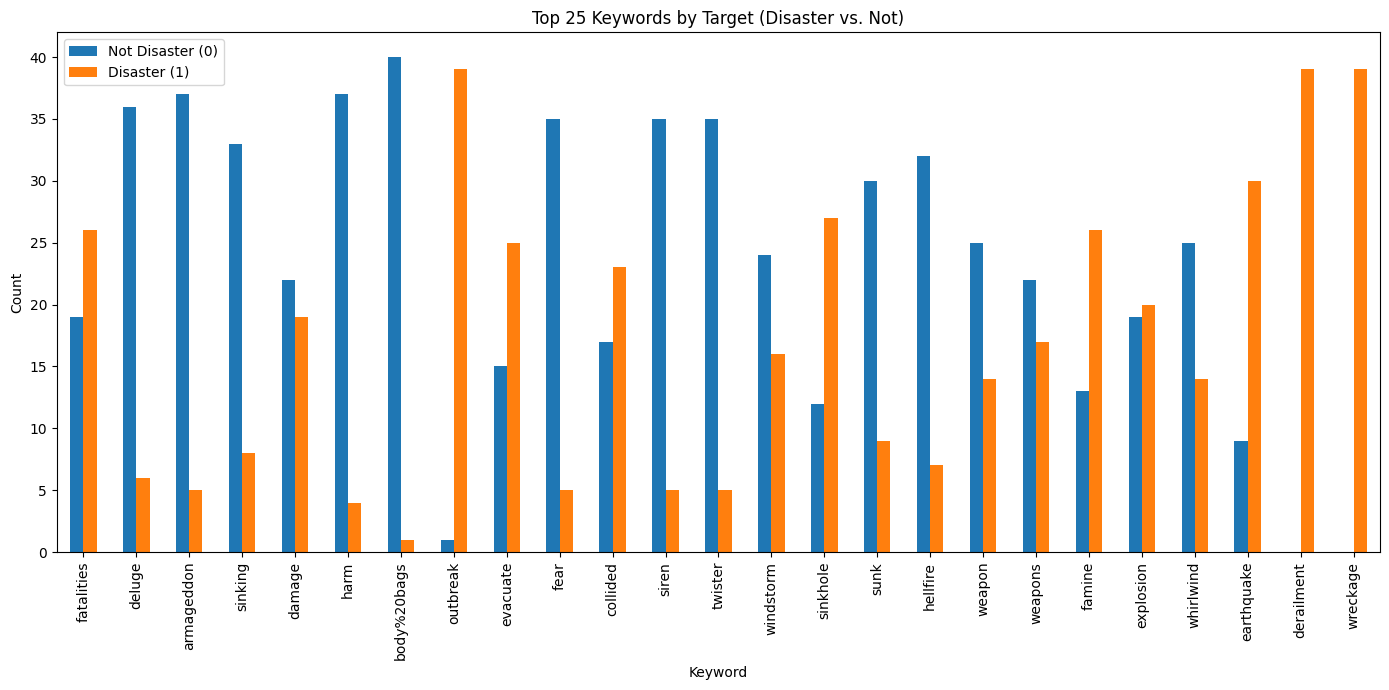

In [12]:
keywordTgtCounts = train.groupby(['keyword','target']).size().unstack(fill_value=0)

if train['keyword'].isna().any():
    if 'unknown' in keywordTgtCounts.index:
        keywordTgtCounts = keywordTgtCounts.rename(index={'unknown':'NaN'})

topKeys = keywordTgtCounts.sum(axis=1).sort_values(ascending=False).head(25).index
plotDat = keywordTgtCounts.loc[topKeys]

print(f'Total Unique Keywords (including NaN): {len(keywordTgtCounts)}')

# Plot
fig, ax = plt.subplots(figsize=(14,7))
plotDat.plot(kind='bar',ax=ax)
plt.title('Top 25 Keywords by Target (Disaster vs. Not)')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['Not Disaster (0)', 'Disaster (1)'])
plt.tight_layout()
plt.show()

Class Distribution:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


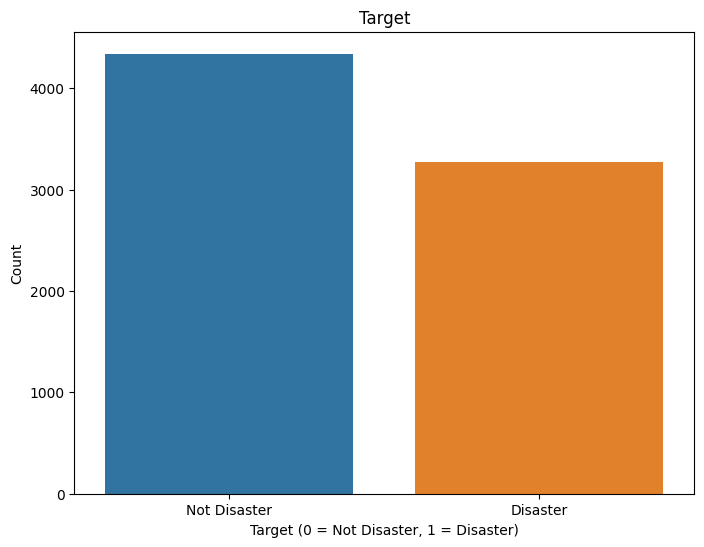

In [15]:
# Count target distribution
tgtCounts = train['target'].value_counts(normalize=True)*100
print(f'Class Distribution:\n{tgtCounts}')

# Plot class distribution
plt.figure(figsize=(8,6))
sns.countplot(x='target',data=train)
plt.title('Target')
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1],['Not Disaster','Disaster'])
plt.show()

## Exploratory Data Analysis Conclusions

We can see we have approximately 7,600 training tweets and 3,200 test tweets to work with. Each has:
* an ID,
* a keyword (potentially blank, as in 61 cases, likely pulled by a human as something that might catch one's eye),
* the location of the tweet (which is blank in 2,500 cases), 
* the text of the tweet
* target/label (in train only)

Initial analysis identified 221 unique keywords, including blanks/unknown/NaNs. Looking at the top 25, it's easy to pick out ones that are not commonly used in contexts other than disasters (i.e. derailment) and those which are used in other contexts (i.e. hellfire). 

Approximately 57% of the tweets are not about real disasters.

# Step 3: Preprocessing
In this section we are going to clean the text to remove things like URLs, usernames, hashtags, punctuation, and non-ASCII characters. We are also going to tokenize the text to get it into a format a machine learning model can understand & process more efficiently.

## Step 3a: Clean Text & Tokenize

In [22]:
def cleanText(text):
    if not isinstance(text,str):
        return ''
        
    else:
        # Convert text to lowercase.
        text = text.lower()
        # Remove URLs, usernames, hashtags, punctuation, non-ASCII characters.
        text = re.sub(r'https?\S+|www.\S+|@\w+|#\w+|[^\w\s]|[^\x00-\x7F]+',' ',text)
        # Normalize white space
        text = re.sub(r'\s+',' ',text).strip()

    return text
        

In [25]:
# Clean the text
train['cleanedText'] = train['text'].apply(cleanText)
test['cleanedText'] = test['text'].apply(cleanText)

# Fill NaN values
train['keyword'].fillna('unknown',inplace=True)
train['location'].fillna('unknown',inplace=True)
test['keyword'].fillna('unknown',inplace=True)
test['location'].fillna('unknown',inplace=True)

print('Sample of cleaned text:')
for ii in range(33,35):
    print(f"\nOriginal: {train['text'].iloc[ii]}")
    print(f"Cleaned: {train['cleanedText'].iloc[ii]}")

Sample of cleaned text:

Original: #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
Cleaned: breaking news nigeria flag set ablaze in aba

Original: Crying out for more! Set me ablaze
Cleaned: crying out for more set me ablaze


In [28]:
# Now to tokenize the text!
maxWords = 20000
maxLen = 100

tokens = Tokenizer(num_words=maxWords)
tokens.fit_on_texts(train['cleanedText'])

trainSeq = tokens.texts_to_sequences(train['cleanedText'])
testSeq = tokens.texts_to_sequences(test['cleanedText'])

trainSeq = pad_sequences(trainSeq,maxlen=maxLen)
testSeq = pad_sequences(testSeq,maxlen=maxLen)
targets = train['target'].values

We're using the keras tokenizer here as part of the text processing. A tokenizer converts works into integers partially based on frequency. Later, the embedding layer we sneak into our model will transform the integers into dense vectors which are learned during training.

There are plenty of other methods out there, like TF-IDF vectorization, which we saw in the BBC New Classification challenge). TF-IDF is a statistical method that evaluates the importance of a word in a document relative to a collection of documents. Other vectorizations include GloVe (Global Vectors for Word Representation), which learns vector representation of words based on their co-occurrence statistics within a body of work/collection of documents. 

## Step 3b: Split the data.

In [29]:
trainSet,valSet,trainTgt,valTgt = train_test_split(trainSeq,targets,test_size=0.2,random_state=27,stratify=targets)

In [32]:
# Create datasets for efficient loading!
def makeSuitcase(feats,labels,batchSize=64,isTrain=True):
    dat = tf.data.Dataset.from_tensor_slices((feats,labels))

    if isTrain:
        dat = dat.shuffle(buffer_size=10000)

    dat = dat.batch(batchSize)
    dat = dat.prefetch(tf.data.experimental.AUTOTUNE)

    return dat

In [50]:
# Why did I call that function "makeSuitcase"? I'm not sure.
# I think it was something about making a set out of data. It's late,
# and the next thing my brain said was set = suitcase. So. Yeah.
trainDat = makeSuitcase(trainSet,trainTgt)
valDat = makeSuitcase(valSet,valTgt,isTrain=False)

# Step 4: Build and Train the Model!
We're using GRU here because it handles sequential data pretty effectively while neatly sidestepping the vanishing gradient problem common in other RNNs.

Word embeddings (as seen below) convert text into numerical vectors which capture semantic meaning (because computers don't speak people). Embeddings place semantically similar words closer in vector space.

## Step 4a: Build and Train

### Quick Note: the GRU

A GRU (Gated Recurrent Unit) is a type of RNN that uses gating mechanisms to selectively update the hidden state at each time step, allowing them to remember important information while discarding irrelevant details. They want to simplify Long Short-Term Memory (LSTM) network architecture by merging some of its components. 

GRUs are more computantionally efficient because they combine the forget and input gates into a single update gate. However, the LSTM still outperforms the GRU in tasks requiring long-term memory.

In [47]:
def buildMeAGru(embeddingDim=128,units=64,dropout=0.2):
    inputs = layers.Input(shape=(maxLen,))

    x = layers.Embedding(maxWords,embeddingDim,input_length=maxLen)(inputs)
    x = layers.SpatialDropout1D(dropout)(x)
    x = layers.GRU(units,dropout=dropout,recurrent_dropout=dropout)(x)
    outs = layers.Dense(1,activation='sigmoid')(x)

    model = models.Model(inputs,outs)

    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [55]:
# Set up the callbacks.
# I kind of love callbacks? I just learned about them recently 
# and they seem pretty darn useful. 
aintNoHollaBacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='bestGru.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [48]:
# Train me!
gruModel = buildMeAGru()

print('GRU Model Summary:')
gruModel.summary()

GRU Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 100, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,597,313 (9.91 MB)

 Trainable params: 2,597,313 (9.91 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
print('Training GRU...')
gruHist = gruModel.fit(
    trainDat,
    epochs=10,
    validation_data=valDat,
    callbacks=aintNoHollaBacks,
    verbose=1
)

historyDF = pd.DataFrame(gruHist.history)
historyDF.to_csv('training_history.csv',index=False)

Training GRU...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9294 - loss: 0.1900
Epoch 1: val_loss did not improve from 0.50535
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9293 - loss: 0.1902 - val_accuracy: 0.7820 - val_loss: 0.5098 - learning_rate: 1.5625e-05
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9251 - loss: 0.2123
Epoch 2: val_loss did not improve from 0.50535
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.9251 - loss: 0.2122 - val_accuracy: 0.7827 - val_loss: 0.5115 - learning_rate: 1.5625e-05
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9204 - loss: 0.2094
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 3: val_loss did not improve from 0.50535
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.9204 - loss: 0.2093 - val_accuracy: 0.7814 - val_loss: 0.5135 - learning_rate: 1.5625e-05
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9241 - loss: 0

## Step 4b: Initial Results

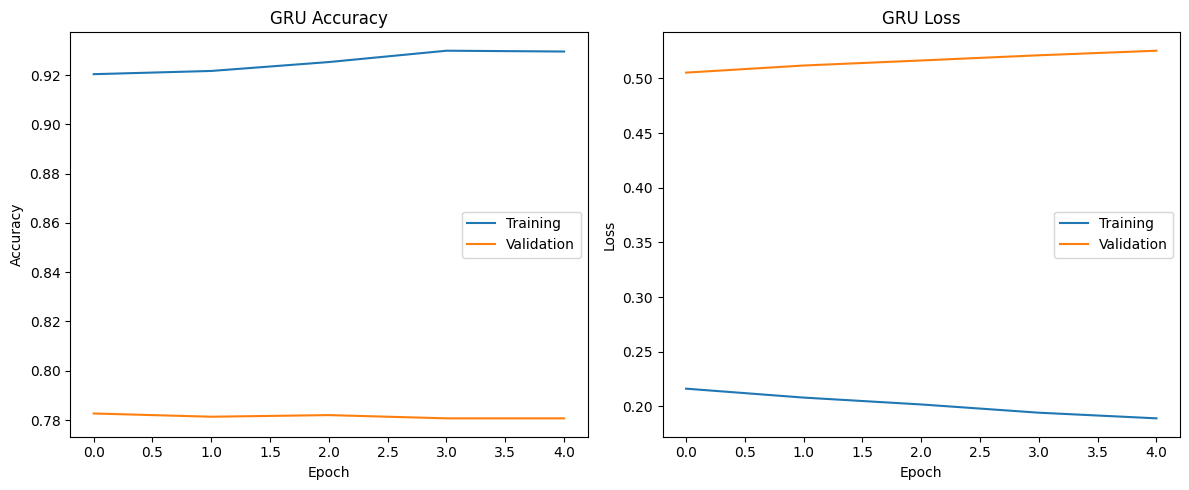

In [57]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(gruHist.history['accuracy'],label='Training')
plt.plot(gruHist.history['val_accuracy'],label='Validation')
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(gruHist.history['loss'],label='Training')
plt.plot(gruHist.history['val_loss'],label='Validation')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# Evaluate the model on the actual validation set.
yPred = gruModel.predict(valDat,batch_size=128)
yPredClasses = (yPred > 0.5).astype(int).flatten()

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


GRU Model Results:
Validation Accuracy: 0.7827
Validation F1 Score: 0.7354

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.79      0.84      0.82       869
    Disaster       0.77      0.70      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



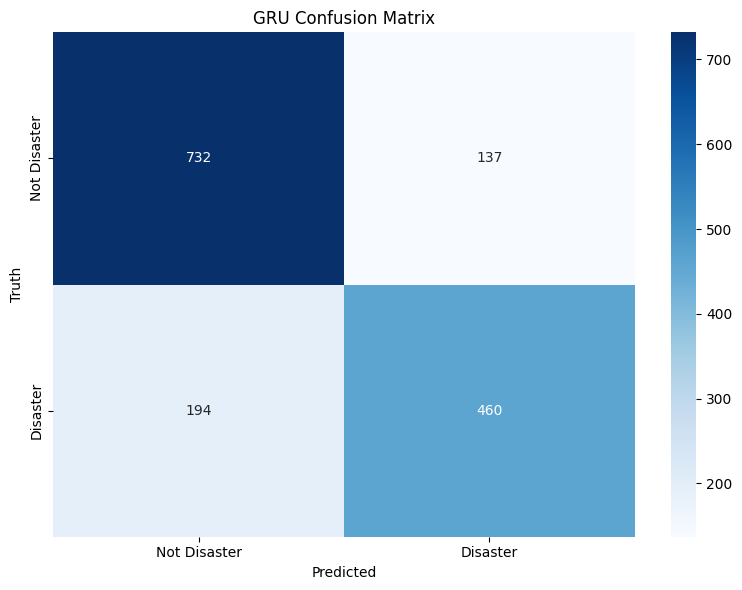

In [64]:
# Calculate metrics
accuracy = np.mean(yPredClasses == valTgt)
f1 = f1_score(valTgt,yPredClasses)
cm = confusion_matrix(valTgt,yPredClasses)

print('GRU Model Results:')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

print('\nClassification Report:')
print(classification_report(valTgt,yPredClasses,target_names=['Not Disaster','Disaster']))

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Disaster','Disaster'],
    yticklabels=['Not Disaster','Disaster']
)
plt.title('GRU Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.tight_layout()
plt.show()

# Step 5: Hyperparameter Tuning

Let's check some other hyperparameter values!

In [98]:
hyperLife = [
    {'embed': 128, 'units': 64, 'drop': 0.2}, # baseline!
    {'embed': 128, 'units': 64, 'drop': 0.3}, # higher drop
    {'embed': 256, 'units': 64, 'drop': 0.2}, # higher embed
    {'embed': 128, 'units': 128, 'drop': 0.2}, # many units
    {'embed': 128, 'units': 128, 'drop': 0.1}, # more units, less drop
    {'embed': 100, 'units': 64, 'drop': 0.1}, # smol
    {'embed': 200, 'units': 150, 'drop': 0.3}, # big boy, metric units
]

# So they're tuned models, right? And a tuned model piano...
# Is a Yamaha, because it's a keyboard. Someone kill me.
yamahas = []

In [99]:
for ii, params in enumerate(hyperLife):
    model = buildMeAGru(embeddingDim=params['embed'],
                        units=params['units'],
                        dropout=params['drop']
                       )
    # Train the model
    model.fit(
        trainDat,
        epochs=10,
        validation_data=valDat,
        callbacks=aintNoHollaBacks,
        verbose=0
    )

    # Evaluate its performance
    yProbs = model.predict(valSet,batch_size=128)
    yPred = (yProbs > 0.5).astype(int).flatten()

    acc = accuracy_score(valTgt,yPred)
    f1 = f1_score(valTgt,yPred)

    yamahas.append({
        'model': model,
        'params': params,
        'accuracy': acc,
        'f1_score': f1
    })

print('\n\nAll done!')


Epoch 1: val_loss did not improve from 0.45797

Epoch 2: val_loss did not improve from 0.45797

Epoch 3: val_loss did not improve from 0.45797

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.45797

Epoch 5: val_loss did not improve from 0.45797

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 6: val_loss did not improve from 0.45797
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step

Epoch 1: val_loss did not improve from 0.45797

Epoch 2: val_loss did not improve from 0.45797

Epoch 3: val_loss did not improve from 0.45797

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.45797

Epoch 5: val_loss did not improve from 0.45797

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 6: val_loss did not improve from 0

In [105]:
# Pick the best model!
yamahasDF = pd.DataFrame(yamahas)
print(yamahasDF)

                                         model  \
0  <Functional name=functional_15, built=True>   
1  <Functional name=functional_16, built=True>   
2  <Functional name=functional_17, built=True>   
3  <Functional name=functional_18, built=True>   
4  <Functional name=functional_19, built=True>   
5  <Functional name=functional_20, built=True>   
6  <Functional name=functional_21, built=True>   

                                      params  accuracy  f1_score  
0   {'embed': 128, 'units': 64, 'drop': 0.2}  0.786605  0.728941  
1   {'embed': 128, 'units': 64, 'drop': 0.3}  0.790545  0.741281  
2   {'embed': 256, 'units': 64, 'drop': 0.2}  0.791202  0.733221  
3  {'embed': 128, 'units': 128, 'drop': 0.2}  0.784636  0.731588  
4  {'embed': 128, 'units': 128, 'drop': 0.1}  0.801051  0.735833  
5   {'embed': 100, 'units': 64, 'drop': 0.1}  0.787262  0.729549  
6  {'embed': 200, 'units': 150, 'drop': 0.3}  0.796454  0.734589  


In [117]:
bestModel = yamahasDF[yamahasDF['f1_score']==max(yamahasDF['f1_score'])]
print(bestModel)
bestMod = yamahas[1] # <-- it's best I swear

## Hyperparameter Tuning Conclusions

Increasing the dropout rate tended to increase the F1 Score. Increasing the embeddings decreased the F1 score and the accuracy. Increasing the units gave a bump in the F1 score, but at the cost of accuracy. More units made the models better at learning, but perhaps to the point of overfitting.

## Step 6: Generate Predictions for Submission

In [119]:
testDat = tf.data.Dataset.from_tensor_slices(testSeq).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
testProbs = bestMod['model'].predict(testDat)

testPreds = (testProbs > 0.5).astype(int).flatten()

submitMe = pd.DataFrame({
    'id': test['id'],
    'target': testPreds
})

submitMe.to_csv('submission.csv',index=False)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


# In Conclusion!

In this project, we used a recurrent neural network (RNN) to classify disaster-related tweets as a real disaster or a fake disaster. The final best model was a GRU RNN with parameters as follows:
* embedding dimensions: 128
* units: 64
* dropout rate: 0.3

One of the most important factors in model success with NLP is (as with many machine learning applications, honestly) the data itself. Thus cleaning the data and appropriately vectorizing or tokenizing it is imperative. Removing unnecessary characters like URLs, usernames, and hashtags from the tweets allowed the model to focus on the semantics of the message and categorize it appropriately.

In the future, it could be beneficial to explore other vectorizations/tokenizations like GloVe, Word2Vec, or TF-IDF because they can capture broader semantic relationships than the small set of data employed in this project.

# References:

Me, talking about TF-IDF:
https://www.kaggle.com/code/altasshrugs/bbcnewsclassification

Stanford, talking about GloVe:
https://nlp.stanford.edu/projects/glove/

This code base, which helped me get started: 
https://www.kaggle.com/code/carlosmatherson/nlp-with-disaster-tweets-rnn